## Main Function

Established serial connection to Arduino
Collected data from arduino: d



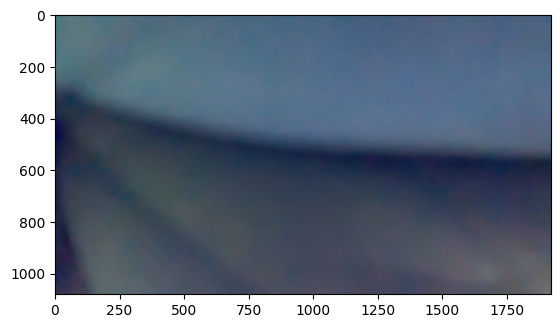

min: 2 max: 152


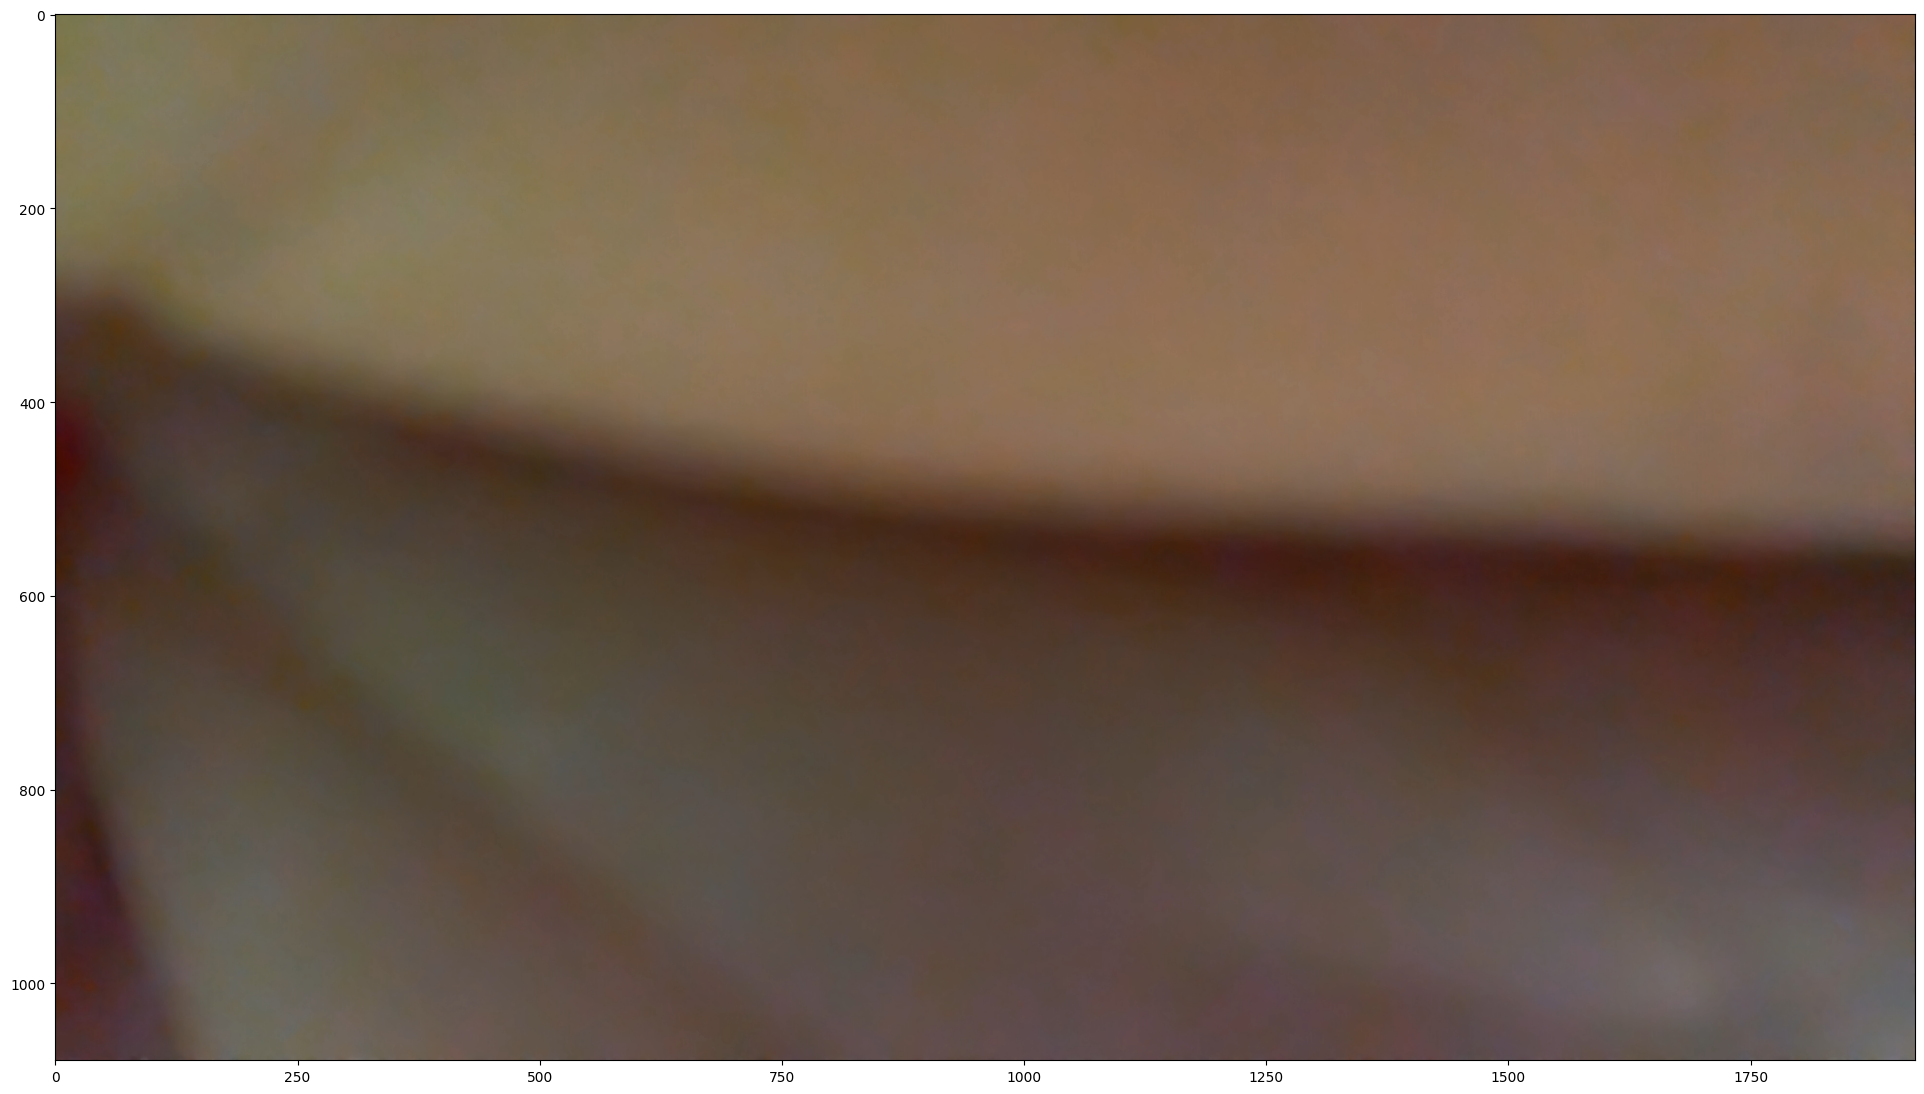

In [13]:
list_values = []
IMAGES_FOR_TEST = {}
while True:
    if soil_moisture_activate():
        camera = cv2.VideoCapture(0)
        time.sleep(3)
        take_and_save_photo()
        image_np = loading_image()
        result = inference(image_np, hub_model)
        determine_yell(result)  
        break

In [22]:
pip install tensorflow protobuf==3.20.3 tensorflow-hub twilio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.9/343.9 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pathlib
import cv2
import logging
logging.disable(logging.WARNING)

import matplotlib
import matplotlib.pyplot as plt
import time

import numpy as np
from six import BytesIO
from PIL import Image
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

import serial

from IPython.display import Audio
from IPython.core.display import display

from twilio.rest import Client

tf.get_logger().setLevel('ERROR')


/var/folders/y7/w740pwz129s5nm6pf97h2zs40000gn/T/ipykernel_42970/3200664520.py:22: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# Select Model

In [2]:
model_handle = 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1'
hub_model = hub.load(model_handle)

2023-09-16 21:39:13.476143: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-16 21:39:13.476164: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


## Arduino Response

In [3]:
def soil_moisture_activate():
    arduino = serial.Serial('/dev/cu.usbmodem2101', 9600) # Change com3 when testing
    print('Established serial connection to Arduino')
    arduino_data = arduino.readline()
    
    decoded_value = str(arduino_data[0:len(arduino_data)].decode("utf-8"))
    print(f"Collected data from arduino: {decoded_value}")
    if not decoded_value:
        arduino.close()
        return False
    arduino.close()
    return True

## Webcam to take picture

In [4]:
def take_and_save_photo():
    ret, frame = camera.read()
    plt.imshow(frame)
    plt.show()
    camera.release()
    cv2.imwrite("photo.png", frame)

    # path to an image
    IMAGES_FOR_TEST["Image1"] = "photo.png"

In [5]:
def load_image_into_numpy_array(path):
    image = None
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
    (1, im_height, im_width, 3)).astype(np.uint8)

In [6]:
def loading_image():
    #@title Image Selection (don't forget to execute the cell!) { display-mode: "form"}
    selected_image = 'Image1' # @param ['Image1']

    image_path = IMAGES_FOR_TEST[selected_image]
    Image.open(image_path)
    image_np = load_image_into_numpy_array(image_path)

    print('min:',np.min(image_np[0]), 'max:', np.max(image_np[0]))
    plt.figure(figsize=(24,32))
    plt.imshow(image_np[0])
    #plt.show()
    return image_np

## Use ML model to make inference

In [7]:
def inference(image_np, hub_model_fn):
    # running inference
    results = hub_model_fn(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
    return result

## Determine if yelling is needed

In [12]:
def play_sound():
    display(Audio('goat-scream.mp3', autoplay=True))

def send_text():
    client = Client('AC98764163f3ce7dad3be0dc1ccc965818', '49ef36070d093245ea655780ce315349')
    message = client.messages.create(
        body='Bruh. Wata me!',
        from_='+16264653148',
        to='+12263499481'
    )

def determine_yell(result):

    for i in range(result['detection_classes'][0].size):
        if result['detection_scores'][0][i] > 0.6 and result['detection_classes'][0][i] == 1.0:
            play_sound()
            break
    send_text()